In [1]:
import h5py

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from rfest import splineLG
from rfest import get_stimulus_design_matrix, get_spatial_and_temporal_filters

In [2]:
# Plotting helper 
def plot_RF(k, dims, title=''):
    
    import matplotlib.gridspec as gridspec
    
    k_norm = k / np.linalg.norm(k)
    
    sRF, tRF = get_spatial_and_temporal_filters(k_norm, dims)
    
    fig = plt.figure(figsize=(7,6))
    spec = gridspec.GridSpec(ncols=5, nrows=3, figure=fig)
    ax0 = fig.add_subplot(spec[:2, :2])
    ax0.imshow(sRF, origin='lower', cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
    ax0.set_title('Spatial filter')
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax1 = fig.add_subplot(spec[:2, 2:])
    
    labels = ['-800', '-600', '-400', '-200', '0 ms']
    ax1.plot(labels, tRF, 'ko-')
    ax1.set_ylim(-0.8, 0.8)
    ax1.set_title('Temporal filter')
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    
    
    for i in range(dims[0]):
        ax = fig.add_subplot(spec[2, i])
        ax.imshow(k_norm.reshape(dims)[i], origin='lower', cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
        ax.set_title(labels[i])
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig.suptitle(title, fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Load RGC calcium imaging data

In [3]:
with h5py.File('./data/RGC_dendrite.h5', 'r') as f:
    
    stimulus = np.array(f['stimulus'])
    response = np.array(f['response']) 
    
print("# rois = {}".format(response.shape[0]))

# rois = 19


In [4]:
roi_id = 0
dims = [5, 20, 15]
X = get_stimulus_design_matrix(stimulus, dims[0])
y = response[roi_id] 

# Receptive Field Estimation with Natural Cubic Regression Spline

Raw STA, raw maximum likelihood and spline-based maximum likelihood are calculated for free when `splineLG` class is initialized. Call `splineLG().fit()` to get least-square estimation with ElasticNet (`alpha` control the balance between L1 and L2 regularization, `lambda` control the overall weight of the regularization term).

In [5]:
cr = splineLG(X, y, dims, df=7, smooth='cr', compute_mle=True)
cr.fit(num_iters=1500, alpha=1, lambd=0.03, verbal=100) # verbal=0: no progress; 
                                                        # verbal=n: print progress at every n steps

Iter	Cost	
0	1.114	
100	0.870	
200	0.812	
300	0.745	
400	0.674	
500	0.602	
600	0.536	
700	0.476	
800	0.431	
900	0.392	
1000	0.360	
1100	0.335	
1200	0.316	
1300	0.303	
Stop at 1350 steps: cost has been monotonically increasing for 10 steps.


# Receptive Field Estimation with Thin Plate Regression Spline


In [6]:
tp = splineLG(X, y, dims, df=7, smooth='tp', compute_mle=True)
tp.fit(num_iters=1500, alpha=1, lambd=0.03, verbal=100) # verbal=0: no progress; 
                                                        # verbal=n: print progress at every n steps

Iter	Cost	
0	26449.994	
100	26439.704	
200	26429.414	
300	26419.136	
400	26408.880	
500	26398.650	
600	26388.420	
700	26378.190	
800	26367.960	
900	26357.730	
1000	26347.517	
1100	26337.317	
1200	26327.117	
1300	26316.917	
1400	26306.746	
Stop: reached 1500 steps, final cost=26296.67724.


### Plot Results

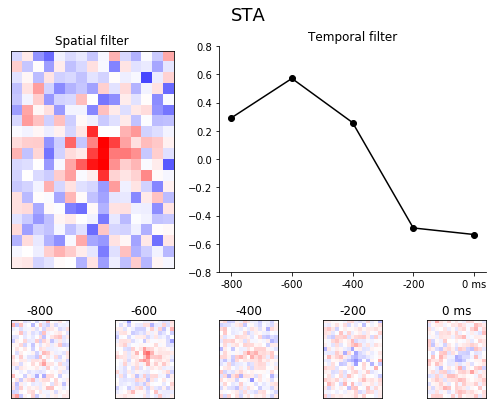

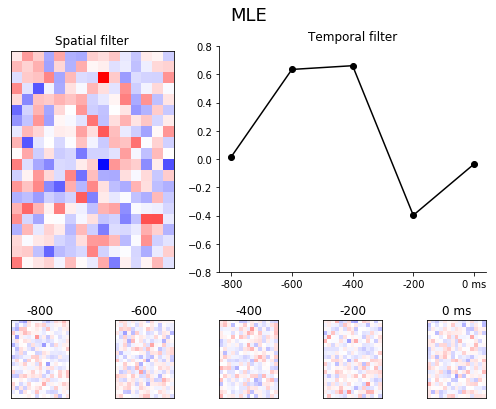

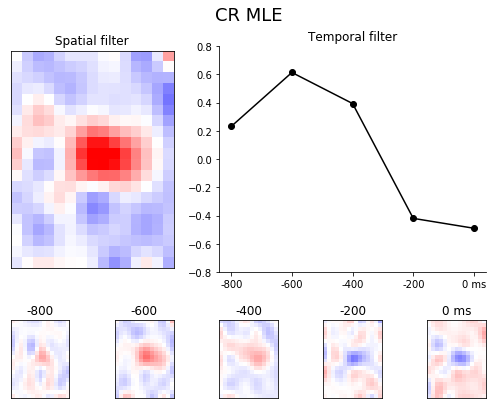

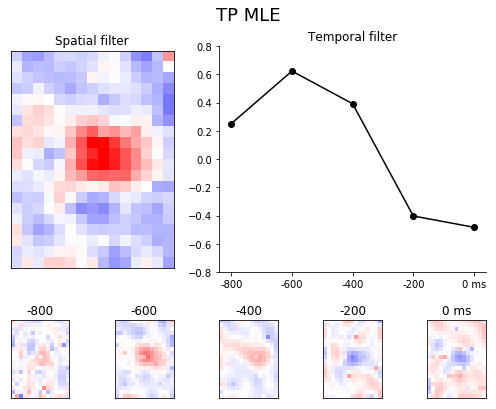

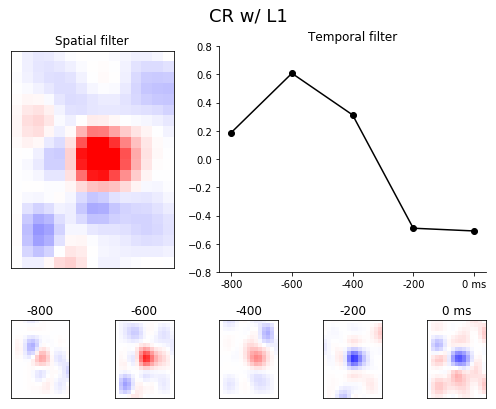

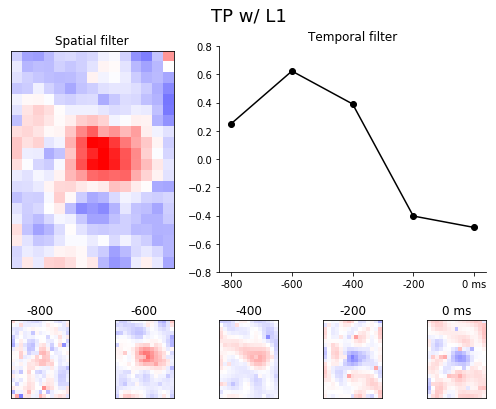

In [7]:
plot_RF(tp.w_sta, dims, 'STA')
plot_RF(tp.w_mle, dims, 'MLE')
plot_RF(cr.w_spl, dims, 'CR MLE')
plot_RF(tp.w_spl, dims, 'TP MLE')
plot_RF(cr.w_opt, dims, 'CR w/ L1')
plot_RF(tp.w_opt, dims, 'TP w/ L1')